In [4]:
import warnings
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import torch

from torchvision import transforms
from torcheval.metrics import R2Score

from torch.utils.data import DataLoader, ConcatDataset
from torch.optim import AdamW

from transformers import get_scheduler
from sklearn.metrics import PredictionErrorDisplay

from jre_utils.config import asset_types
from jre_utils.datapath import (
    model_ready_data_paths,
    model_output_data_paths,
    DATA_DIRECTORY_PATH,
)
from jre_utils.process import get_most_active_municipalities
from jre_utils.data import JapanRETimeSeriesDataset, PadAndMask, ToNumpy, ToTensor
from jre_utils.models import (
    TimeSeriesTransformerModel,
    TimeSeriesTransformerDecoderModel,
)
from jre_utils.metrics import MSELossWeighted
from jre_utils.engine import (
    evaluate_weighted,
    train_weighted,
)
from jre_utils.backtest import predict_returns

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [2]:
# The goal is to have as many factors as possible to help the model discern differences between municipalities with high growth, and municipalities with low growth.

### Config


In [5]:
dataset_asset_type = "combined"
dataset_key = "transactions"
years_ahead = 4

metrics = {
    "median": "unit_price_median",
    "gmean": "unit_price_gmean",
    "robust": "robust_price_index",
    "ols": "ols_price_index",
}

granularity_columns = ["area", "area_code"]
group_by_columns = granularity_columns + ["year"]

metric_key = "robust"
metric = metrics[metric_key]
metric_sharpe = metric + "_sharpe"
normalized_metric_sharpe = metric_sharpe + "_normalized_yearly"

In [6]:
start_year = 2007
eval_start_year = 2021  # eval_years = [2021, 2022]
eval_end_year = 2022

dataset_name = f"sequence_{dataset_key}_{dataset_asset_type}_{metric_key}_{years_ahead}"
output_dataset_name = f"{dataset_name}_{eval_start_year}"
model_ready_data_path = model_ready_data_paths[dataset_name]
model_output_data_path = model_output_data_paths[output_dataset_name]

In [7]:
id_columns = ["area_code", "area", "year"]

original_factor_columns = [
    "total_tax_growth",
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "net_migration_ratio",
    "new_dwellings_ratio",
    "taxpayer_count_growth",
]

factor_log_normalize_columns = [
    "population",
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "net_migration_ratio",
    "new_dwellings_ratio",
    "taxpayer_count_growth",
]

factor_normalize_columns = []

factor_maintain_columns = [
    "migrations_is_available",
    "taxable_income_is_available",
    "dwellings_is_available",
    "total_tax_is_available",
]

factor_columns = (
    [f"{column}_log_normalized_yearly" for column in factor_log_normalize_columns]
    + [f"{column}_normalized_yearly" for column in factor_normalize_columns]
    + factor_maintain_columns
    # + original_factor_columns
)

final_factor_columns = (
    factor_normalize_columns + factor_log_normalize_columns + factor_columns
)

In [8]:
# asset_types_to_train = list(asset_types.keys())
asset_types_to_train = ["building"]
asset_types_as_factors = list(set(asset_types_to_train + ["building"]))

# Test withour price factors
# core_log_normalize_columns = []
# core_normalize_columns = []
core_log_normalize_columns = ["count", "yearly_price_growth"]
core_normalize_columns = [metric_sharpe]
core_maintain_columns = ["metric_sharpe_is_available"]

core_columns = (
    [f"{column}_log_normalized_yearly" for column in core_log_normalize_columns]
    + [f"{column}_normalized_yearly" for column in core_normalize_columns]
    + core_maintain_columns
)

# combined_core_columns = [
#     f"{asset_type}_{column}"
#     for column in core_columns
#     for asset_type in asset_types_as_factors
# ]

In [9]:
# feature_columns = factor_columns + combined_core_columns + ["land", "condo"]
# extra_prediction_columns = [f"{column}_log_normalized_yearly" for column in factor_log_normalize_columns]

In [10]:
extra_prediction_columns = []


def get_feature_columns_for_asset_type(asset_type, include_label=True):
    asset_core_columns = [f"{asset_type}_{column}" for column in core_columns]
    return (
        asset_core_columns
        + factor_columns
        + (["land", "condo"] if include_label else [])
    )

In [11]:
def drop_invalid_rows(df, column):
    return df[~df[column].isna()].reset_index(drop=True)

### Dataset Prep


In [13]:
df = pd.read_csv(model_ready_data_path)
df = df[df["year"] <= eval_end_year]
df = df.sample(frac=1).reset_index(drop=True)
df = df.sort_values(by=["year"]).reset_index(drop=True)
# df = get_most_active_municipalities(df, count_column=f"population", n=500)

df["area_code"] = df["area_code"].astype(str)

# Weighting by population
df["log_population"] = df["population"].apply(lambda x: np.log10(1 + x))
df["weight"] = df.groupby("year")["log_population"].transform(lambda x: x - x.min() + 1)
# df["weight"] = 1

# Split into Train and Eval
train_df = df[(df["year"] >= start_year) & (df["year"] < eval_start_year)]
eval_df = df[df["year"] >= eval_start_year]

train_dfs = {
    asset_type: drop_invalid_rows(train_df, f"{asset_type}_{normalized_metric_sharpe}")
    for asset_type in asset_types_to_train
}

eval_dfs = {
    asset_type: drop_invalid_rows(eval_df, f"{asset_type}_{normalized_metric_sharpe}")
    for asset_type in asset_types_to_train
}

# Finally
df = df.fillna(0)

for asset_type in asset_types_to_train:
    print(
        f"{asset_type} -> Train: {train_dfs[asset_type].shape}, Eval: {eval_dfs[asset_type].shape}"
    )

building -> Train: (10214, 81), Eval: (2222, 81)


<Axes: ylabel='Frequency'>

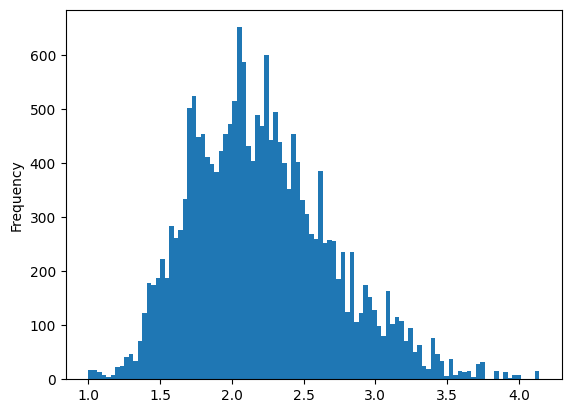

In [14]:
df["weight"].plot.hist(bins=100)

In [15]:
asset_type = "building"
tmp_train_df, tmp_eval_df = train_dfs[asset_type], eval_dfs[asset_type]

tmp_train_df[(tmp_train_df["area_code"] == "13102")][
    ["year", f"{asset_type}_{normalized_metric_sharpe}"]
]

year  building_robust_price_index_sharpe_normalized_yearly
53    2010                                           0.127597   
167   2011                                          -0.524783   
831   2012                                          -0.291025   
1819  2013                                           0.857159   
2552  2014                                           3.179896   
4422  2015                                           3.077448   
5678  2016                                           6.424525   
6139  2017                                           6.857898   
7481  2018                                           6.592115   
8137  2019                                           2.536894   
9123  2020                                           2.078865

In [16]:
tmp_eval_df[(tmp_eval_df["area_code"] == "13102")][
    ["year", f"{asset_type}_{normalized_metric_sharpe}"]
]

year  building_robust_price_index_sharpe_normalized_yearly
27    2021                                           1.225365   
1829  2022                                           1.101701

In [17]:
from jre_utils.process import get_window

idx = tmp_eval_df[(tmp_eval_df["area_code"] == "13102")].index[-2]
row = tmp_eval_df.iloc[idx]
target = row[f"{asset_type}_{normalized_metric_sharpe}"]
area_code, year = row["area_code"], row["year"]
window = get_window(df, area_code, year - years_ahead, 5)

print(f"Target: {target}")
window[get_feature_columns_for_asset_type(asset_type, include_label=False)].round(3)
# window

Target: 1.2253654480384495


building_count_log_normalized_yearly  \
7230                                  0.750   
8077                                  0.599   
10188                                 0.540   
11618                                 0.585   
12140                                 0.410   

       building_yearly_price_growth_log_normalized_yearly  \
7230                                               0.439    
8077                                               0.864    
10188                                              0.799    
11618                                              0.476    
12140                                              0.624    

       building_robust_price_index_sharpe_normalized_yearly  \
7230                                               0.857      
8077                                               3.180      
10188                                              3.077      
11618                                              6.425      
12140                                              6.858      

       building_metric_sharpe_is_available  population_log_normalized_yearly  \
7230                                   1.0                             1.060   
8077                                   1.0                             1.075   
10188                                  1.0                             1.095   
11618                                  1.0                             1.110   
12140                                  1.0                             1.130   

       taxable_income_growth_log_normalized_yearly  \
7230                                         1.041   
8077                                         1.929   
10188                                        1.181   
11618                                        1.491   
12140                                        1.516   

       taxable_income_per_taxpayer_growth_log_normalized_yearly  \
7230                                               0.734          
8077                                               1.457          
10188                                             -0.166          
11618                                              0.894          
12140                                              0.558          

       net_migration_ratio_log_normalized_yearly  \
7230                                       3.232   
8077                                       4.114   
10188                                      3.537   
11618                                      4.079   
12140                                      4.132   

       new_dwellings_ratio_log_normalized_yearly  \
7230                                       3.046   
8077                                       3.523   
10188                                      1.902   
11618                                      7.613   
12140                                      1.531   

       taxpayer_count_growth_log_normalized_yearly  migrations_is_available  \
7230                                         0.799                        1   
8077                                         1.587                        1   
10188                                        2.663                        1   
11618                                        1.467                        1   
12140                                        1.819                        1   

       taxable_income_is_available  dwellings_is_available  \
7230                             1                       1   
8077                             1                       1   
10188                            1                       1   
11618                            1                       1   
12140                            1                       1   

       total_tax_is_available  
7230                        1  
8077                        1  
10188                       1  
11618                       1  
12140                       1

In [18]:
# window[["year", "area_code", "building_unit_price_gmean_pct_chg_normalized_yearly", "population_log_normalized_yearly"] + original_factor_columns].round(3).to_csv("sample.csv", index=False)

In [19]:
window_length = 5

In [20]:
time_series_dataset = JapanRETimeSeriesDataset(
    df,
    tmp_train_df,
    metrics=[f"{asset_type}_{normalized_metric_sharpe}"] + extra_prediction_columns,
    weight_column=f"weight",
    asset_type=asset_type,
    feature_columns=get_feature_columns_for_asset_type(
        asset_type, include_label=len(asset_types_to_train) > 1
    ),
    shift=years_ahead,
    window_length=window_length,
)

time_series_dataset_transformed = JapanRETimeSeriesDataset(
    df,
    tmp_train_df,
    metrics=[f"{asset_type}_{normalized_metric_sharpe}"] + extra_prediction_columns,
    weight_column=f"weight",
    asset_type=asset_type,
    feature_columns=get_feature_columns_for_asset_type(
        asset_type, include_label=len(asset_types_to_train) > 1
    ),
    transform=transforms.Compose(
        [ToNumpy(), PadAndMask(pad_length=window_length), ToTensor()]
    ),
    shift=years_ahead,
    window_length=window_length,
)

for i, sampleX in enumerate(time_series_dataset):
    print(
        i,
        sampleX["window"].shape,
        sampleX["target"].shape,
        sampleX["target"].values,
        sampleX["weight"].values,
    )
    if i == 3:
        break


for i, sampleY in enumerate(time_series_dataset_transformed):
    print(
        i,
        sampleY["window"].shape,
        sampleY["target"].shape,
        sampleY["target"],
        sampleY["weight"],
    )
    if i == 3:
        break

0 (1, 14) (1,) [-4.00858992] [3.17081493]
1 (1, 14) (1,) [0.27913275] [3.0786387]
2 (1, 14) (1,) [0.16888121] [3.40491513]
3 (1, 14) (1,) [0.06252937] [3.40896455]
0 torch.Size([5, 14]) torch.Size([1]) tensor([-4.0086]) tensor([3.1708])
1 torch.Size([5, 14]) torch.Size([1]) tensor([0.2791]) tensor([3.0786])
2 torch.Size([5, 14]) torch.Size([1]) tensor([0.1689]) tensor([3.4049])
3 torch.Size([5, 14]) torch.Size([1]) tensor([0.0625]) tensor([3.4090])


In [21]:
BATCH_SIZE = 256

In [22]:
train_datasets = {
    asset_type: JapanRETimeSeriesDataset(
        df,
        train_dfs[asset_type],
        metrics=[f"{asset_type}_{normalized_metric_sharpe}"] + extra_prediction_columns,
        weight_column=f"weight",
        asset_type=asset_type,
        feature_columns=get_feature_columns_for_asset_type(
            asset_type, include_label=len(asset_types_to_train) > 1
        ),
        transform=transforms.Compose(
            [ToNumpy(), PadAndMask(pad_length=window_length), ToTensor()]
        ),
        shift=years_ahead,
        window_length=window_length,
    )
    for asset_type in asset_types_to_train
}

eval_datasets = {
    asset_type: JapanRETimeSeriesDataset(
        df,
        eval_dfs[asset_type],
        metrics=[f"{asset_type}_{normalized_metric_sharpe}"] + extra_prediction_columns,
        weight_column=f"weight",
        asset_type=asset_type,
        feature_columns=get_feature_columns_for_asset_type(
            asset_type, include_label=len(asset_types_to_train) > 1
        ),
        transform=transforms.Compose(
            [ToNumpy(), PadAndMask(pad_length=window_length), ToTensor()]
        ),
        shift=years_ahead,
        window_length=window_length,
    )
    for asset_type in asset_types_to_train
}

In [23]:
train_dataset = ConcatDataset(list(train_datasets.values()))
eval_dataset = ConcatDataset(list(eval_datasets.values()))

train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

eval_dataloader = DataLoader(
    eval_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

In [24]:
len(train_dataloader)

40

### Building the Transformer Model


In [25]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


In [26]:
# plot num weights over performance to see if size matters at all (H0: it doesn't matter)
n_features = len(
    get_feature_columns_for_asset_type(
        asset_type, include_label=len(asset_types_to_train) > 1
    )
)
nlayers = 4
nhead = 4
d_model = 32 * nhead
d_hid = 32 * nhead
dropout = 0
enc_dropout = 0

# n_features = len(feature_columns)
# nlayers = 6
# nhead = 6
# d_hid = 64 * nhead
# d_model = 64 * nhead # embedding dimensions
# dropout = 0.1
# enc_dropout = 0


# model = TimeSeriesTransformerModel(
#     n_features=n_features,
#     d_model=d_model,
#     nhead=nhead,
#     d_hid=d_hid,
#     nlayers=nlayers,
#     target_size=len(extra_prediction_columns) + 1,
#     dropout=dropout,
#     enc_dropout=enc_dropout,
#     device=device,
# )

model = TimeSeriesTransformerDecoderModel(
    n_features=n_features,
    d_model=d_model,
    nhead=nhead,
    d_hid=d_hid,
    nlayers=nlayers,
    target_size=len(extra_prediction_columns) + 1,
    dropout=dropout,
    enc_dropout=enc_dropout,
    device=device,
)

model = model.to(device)

In [27]:
model.eval()

r2_score = R2Score(device=device)
mse_loss_weighted = MSELossWeighted().to(device)

with torch.no_grad():
    for batch in eval_dataloader:
        window = batch["window"].to(device)
        mask = batch["mask"].to(device)
        target = batch["target"].to(device)
        weight = batch["weight"].to(device)

        outputs = model(window, mask)
        loss = mse_loss_weighted(outputs, target, weight)
        r2_score.update(
            outputs[:, 0].unsqueeze(1).to(device),
            batch["target"][:, 0].unsqueeze(1).to(device),  # get the first column
        )

        print(
            batch["window"].shape,
            batch["mask"].shape,
            batch["target"].shape,
            batch["weight"].shape,
        )

        print(outputs.shape)

        print("Loss:", loss.item())
        print("R2_score:", r2_score.compute().item())

        break

torch.Size([256, 5, 14]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 3.2232775688171387
R2_score: -0.42345309257507324


In [28]:
learning_rate = 3e-4  # 3e-4
weight_decay = 1  # 1
num_epochs = 30

In [29]:
num_training_steps = num_epochs * len(train_dataloader)
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

lr_scheduler = get_scheduler(
    "linear",  # constant
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

train_losses, train_r2_scores = [], []
eval_losses, eval_r2_scores = [], []

In [30]:
# progress_bar = tqdm(range(num_training_steps))
# 8, 8, 0.1 (4y)

progress_bar = None

for epoch in range(num_epochs):
    train_loss, train_r2_score = train_weighted(
        model, train_dataloader, optimizer, lr_scheduler, progress_bar, device=device
    )
    train_losses.append(train_loss)
    train_r2_scores.append(train_r2_score)

    eval_loss, eval_r2_score = evaluate_weighted(model, eval_dataloader, device=device)
    eval_losses.append(eval_loss)
    eval_r2_scores.append(eval_r2_score)

    print(f"Epoch: {epoch}")
    print(f"Train Loss: {train_loss:.4f}, Eval Loss: {eval_loss:.4f}")
    print(f"Train R^2: {train_r2_score:.4f}, Eval R^2: {eval_r2_score:.4f}")

# progress_bar.close()

Epoch: 0
Train Loss: 9.8624, Eval Loss: 7.3263
Train R^2: 0.0078, Eval R^2: 0.1881
Epoch: 1
Train Loss: 9.7463, Eval Loss: 7.1377
Train R^2: 0.0252, Eval R^2: 0.2262
Epoch: 2
Train Loss: 9.3622, Eval Loss: 6.8446
Train R^2: 0.0552, Eval R^2: 0.2548
Epoch: 3
Train Loss: 8.9512, Eval Loss: 6.7482
Train R^2: 0.0976, Eval R^2: 0.2582
Epoch: 4
Train Loss: 8.7455, Eval Loss: 6.8659
Train R^2: 0.1165, Eval R^2: 0.2449
Epoch: 5
Train Loss: 8.4157, Eval Loss: 6.8355
Train R^2: 0.1463, Eval R^2: 0.2532
Epoch: 6
Train Loss: 8.0974, Eval Loss: 6.7116
Train R^2: 0.1764, Eval R^2: 0.2685
Epoch: 7
Train Loss: 8.0190, Eval Loss: 6.7468
Train R^2: 0.1838, Eval R^2: 0.2660
Epoch: 8
Train Loss: 8.1594, Eval Loss: 6.9420
Train R^2: 0.1681, Eval R^2: 0.2455
Epoch: 9
Train Loss: 8.2328, Eval Loss: 7.2455
Train R^2: 0.1580, Eval R^2: 0.2126
Epoch: 10
Train Loss: 8.1758, Eval Loss: 6.7909
Train R^2: 0.1636, Eval R^2: 0.2655
Epoch: 11
Train Loss: 7.8476, Eval Loss: 6.7992
Train R^2: 0.1973, Eval R^2: 0.2655
Ep

KeyboardInterrupt: 

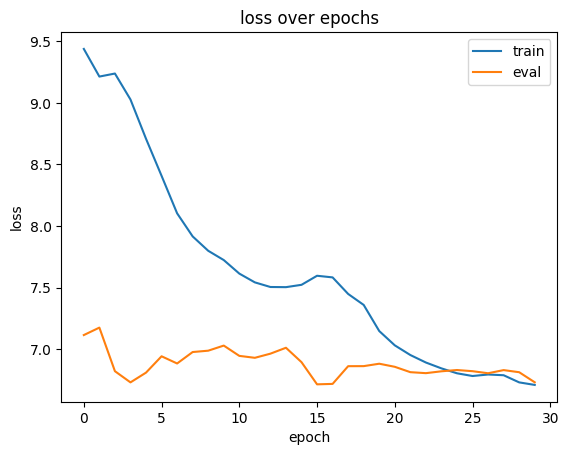

In [ ]:
# Plot MSE
plt.plot(train_losses, label="train")
plt.plot(eval_losses, label="eval")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("loss over epochs")
plt.legend()
plt.show()

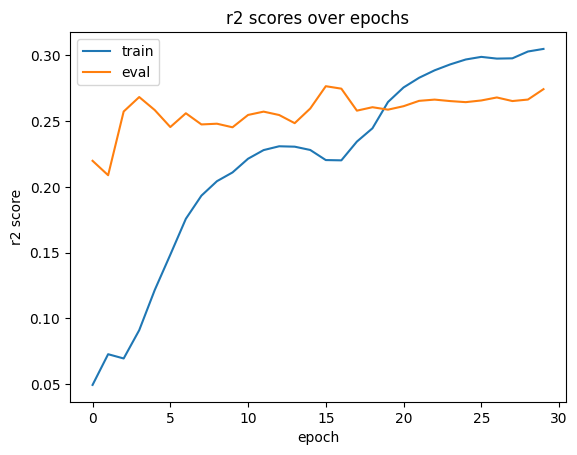

In [318]:
# Plot R2 scores
plt.plot(train_r2_scores, label="train")
plt.plot(eval_r2_scores, label="eval")
plt.xlabel("epoch")
plt.ylabel("r2 score")
plt.title("r2 scores over epochs")
plt.legend()
plt.show()

In [275]:
# smoothed model
loss, epoch_r2_score = evaluate_weighted(model, eval_dataloader, device=device)
print(f"Eval loss: {loss:.4f}")
print(f"Eval R2: {epoch_r2_score:.4f}")

Eval loss: 6.6670
Eval R2: 0.2795


In [276]:
dataset_name = f"sequence_{dataset_key}_{dataset_asset_type}_{metric_key}_{years_ahead}"
model_ready_data_path = model_ready_data_paths[dataset_name]

# Load and Prepare DFs
df = pd.read_csv(model_ready_data_path)
df = df.sample(frac=1).reset_index(drop=True)
df = df.sort_values(by=["year"]).reset_index(drop=True)

yearly_dataframes = {
    asset_type: {
        f"{year}": drop_invalid_rows(
            df[df["year"] == year], f"{asset_type}_{metric_sharpe}"
        )
        for year in [2021, 2022]
    }
    for asset_type in asset_types_to_train
}

df = df.fillna(0)

for investment_asset_type in asset_types_to_train:
    for year in [2021, 2022]:
        dataset_name = (
            f"sequence_{dataset_key}_{investment_asset_type}_{metric_key}_{years_ahead}"
        )
        output_dataset_name = f"{dataset_name}_{year}"
        model_output_data_path = model_output_data_paths[output_dataset_name]

        prediction_df = yearly_dataframes[investment_asset_type][f"{year}"]

        prediction_df["predicted_normalized_return"] = predict_returns(
            model,
            df,
            prediction_df,
            investment_asset_type,
            get_feature_columns_for_asset_type(investment_asset_type, include_label=False),
            device=device,
        )

        prediction_df["asset_type"] = investment_asset_type
        prediction_df[
            [
                "year",
                "area_code",
                "asset_type",
                "predicted_normalized_return",
                f"{investment_asset_type}_yearly_price_growth",
                f"{investment_asset_type}_{metric_sharpe}",
                f"{investment_asset_type}_{normalized_metric_sharpe}",
            ]
        ].to_csv(model_output_data_path, index=False)

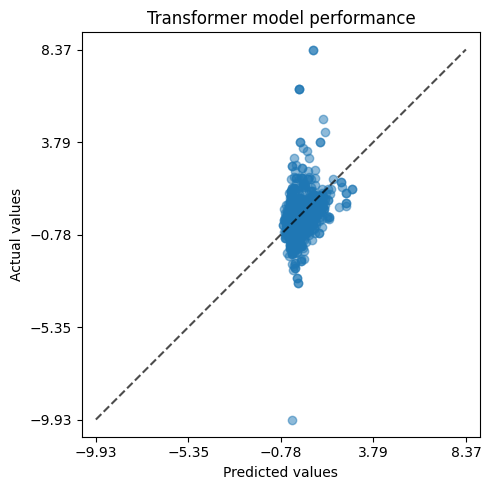

In [277]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    prediction_df[f"{investment_asset_type}_{normalized_metric_sharpe}"],
    prediction_df["predicted_normalized_return"],
    kind="actual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.5},
)
ax.set_title("Transformer model performance")
plt.tight_layout()

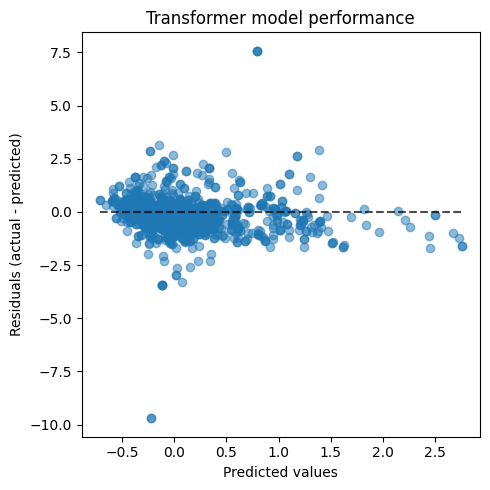

In [278]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    prediction_df[f"{investment_asset_type}_{normalized_metric_sharpe}"],
    prediction_df["predicted_normalized_return"],
    kind="residual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.5},
)
ax.set_title("Transformer model performance")
plt.tight_layout()

In [239]:
model

TimeSeriesTransformerDecoderModel(
  (embedding): Linear(in_features=14, out_features=128, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (transformer_decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0, inplace=False)
        (linear2): Linear(in_features=128, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm3): LayerNorm((128,), eps=1e-05, elementwise_aff

In [240]:
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

Number of parameters: 665601
